## 準備

1. [筆者らGitHub](https://github.com/gifale95/eeg_encoding)をまるごとダウンロードして自分のGoogle Driveの任意の場所に置く．

<p align='center'><img src='https://github.com/SeanNobel/img2eeg/blob/main/figs/pr1.png?raw=True' width='60%'></p>

2. `eeg_encoding-main`下に`project_dir/image_set`を作成し，そこに[データセットページ](https://osf.io/y63gw/)の`test_images.zip`と`training_images.zip`をダウンロードして解凍したものを配置する．(ドライブの容量に余裕があればILSVRC-2012データセットも配置してみても良いと思います)

<p align='center'><img src='https://github.com/SeanNobel/img2eeg/blob/main/figs/pr2.png?raw=True' width='60%'></p>

3. `project_dir`下に`eeg_dataset/preprocessed_data`フォルダを作成し，[preprocessed data](https://osf.io/anp5v/)の`sub-01.zip`を解凍したものを配置する．

<p align='center'><img src='https://github.com/SeanNobel/img2eeg/blob/main/figs/pr3.png?raw=True' width='60%'></p>

In [20]:
# eeg_encoding_mainを配置した自分のGoogle Drive内のパスをここに指定
work_dir = '/content/drive/MyDrive/eeg_encoding-main/'

import os
# Google DriveをColabにマウント
from google.colab import drive
# drive.flush_and_unmount()
drive.mount("/content/drive", force_remount=True)

os.chdir(work_dir)
print(os.getcwd())

# !pip install -r requirements.txt

# 要素にドットでアクセスできる辞書クラス
class Args(dict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__dict__ = self

Mounted at /content/drive
/content/drive/MyDrive/eeg_encoding-main


In [21]:
# import argparse
from torchvision import models
import torch.nn as nn
import numpy as np
import torch
from torch.autograd import Variable as V
from torchvision import transforms as trn
import os
from PIL import Image
import seaborn
import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA

from sklearn.utils import resample
from scipy.stats import pearsonr as corr

## AlexNetを使って画像からfeature mapsを抽出する

[THINGS DATABASE](https://things-initiative.org/):

1854個のコンセプト(carやairplaneなど)それぞれについて10枚の画像が用意されたデータセット．  
論文では200をテストに，1654を訓練に使っている．テストは各コンセプト1枚しか使わないので200枚，訓練は10枚使うので16540枚の画像となる．（今回は10枚だと多すぎるので2枚だけ使います）

<p align='center'><img src='https://github.com/SeanNobel/img2eeg/blob/main/figs/fig2.png?raw=True' width='60%'></p>

論文ではResNet50や他の画像処理ネットワークも使っていますが，とりあえず簡単のためAlexNetのみ使っていこうと思います．

下のセルを実行すると，`project_dir/dnn_feature_maps/full_feature_maps/alexnet/`下の`training_images`に1654*`max_images`個の，`test_images`に200個のファイルが出力されているのがわかります．

In [ ]:
# =============================================================================
# Selecting the layers of interest and importing the model
# =============================================================================
# Lists of AlexNet convolutional and fully connected layers
conv_layers = ['conv1', 'ReLU1', 'maxpool1', 'conv2', 'ReLU2', 'maxpool2',
	'conv3', 'ReLU3', 'conv4', 'ReLU4', 'conv5', 'ReLU5', 'maxpool5']
fully_connected_layers = ['Dropout6', 'fc6', 'ReLU6', 'Dropout7', 'fc7',
	'ReLU7', 'fc8']

class AlexNet(nn.Module):
	def __init__(self):
		"""Selecting the desired layers and importing pretrained weights."""
		super(AlexNet, self).__init__()
		self.select_cov = ['maxpool1', 'maxpool2', 'ReLU3', 'ReLU4', 'maxpool5']
		self.select_fully_connected = ['ReLU6' , 'ReLU7', 'fc8']
		self.feat_list = self.select_cov + self.select_fully_connected
		self.alex_feats = models.alexnet(pretrained=True).features
		self.alex_classifier = models.alexnet(pretrained=True).classifier
		self.avgpool = nn.AdaptiveAvgPool2d((6, 6))

	def forward(self, x):
		"""Extracting the feature maps."""
		features = []
		for name, layer in self.alex_feats._modules.items():
			x = layer(x)
			if conv_layers[int(name)] in self.feat_list:
				features.append(x)
		x = self.avgpool(x)
		x = x.view(x.size(0), -1)
		for name, layer in self.alex_classifier._modules.items():
			x = layer(x)
			if fully_connected_layers[int(name)] in self.feat_list:
				features.append(x)
		return features

model = AlexNet()
if torch.cuda.is_available():
	model.cuda()
model.eval()

In [6]:
"""Extracting and saving the AlexNet feature maps of the training and test images.
"""
# =============================================================================
# Input arguments
# =============================================================================
args = Args({
    'project_dir': work_dir + 'project_dir'
})

print('Extracting feature maps AlexNet <<<')
print('\nInput arguments:')


# =============================================================================
# Defining the image preprocessing
# =============================================================================
centre_crop = trn.Compose([
	trn.Resize((224,224)),
	trn.ToTensor(),
	trn.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


# =============================================================================
# Loading the images and extracting the corresponding feature maps
# =============================================================================
# Extracting the feature maps of (1) training images, (2) test images,
# (3) ILSVRC-2012 validation images, (4) ILSVRC-2012 test images.
# Image directories
max_images = 3 # per concept

img_set_dir = os.path.join(args.project_dir, 'image_set')
img_partitions = os.listdir(img_set_dir)
for p in img_partitions:
	part_dir = os.path.join(img_set_dir, p)
	image_list = []


	for root, dirs, files in os.walk(part_dir):
		images_idx = 0
		for file in files:
			# 訓練データが多すぎて実行に時間がかかるので1654の各conceptについて
			# 最初の画像3枚のみ使う．テストは元々1枚しかないのでOK
			images_idx += 1
			if images_idx > max_images:
				break

			# 処理
			if file.endswith(".jpg") or file.endswith(".JPEG"):
				image_list.append(os.path.join(root,file))
	
	image_list.sort()

	# Extracting and saving the feature maps
	idx = 1
	for image in image_list:
		img = Image.open(image).convert('RGB')
		filename=image.split("/")[-1].split(".")[0]
		input_img = V(centre_crop(img).unsqueeze(0))
		if torch.cuda.is_available():
			input_img=input_img.cuda()
		x = model.forward(input_img)
		feats = {}
		for i,feat in enumerate(x):
			feats[model.feat_list[i]] = feat.data.cpu().numpy()

		# Creating the directory if not existing and saving
		save_dir = os.path.join(args.project_dir, 'dnn_feature_maps',
			'full_feature_maps', 'alexnet', p)
		file_name = p + '_' + format(idx, '07')
		if os.path.isdir(save_dir) == False:
			os.makedirs(save_dir)
		np.save(os.path.join(save_dir, file_name), feats)
		idx += 1

Extracting feature maps AlexNet <<<

Input arguments:


### AlexNetから出てきたデータの形の確認

AlexNetの各層のパラメータの重みが出力されたことがわかります．

論文によると，さっき得られたAlexNetの各層の隠れ状態を結合してPCAで次元削減することによって，EEGに変換するためのfeature mapsが得られます．

In [3]:
weights_path = work_dir + 'project_dir/dnn_feature_maps/full_feature_maps/alexnet/test_images/test_images_0000001.npy'

model_weights = np.load(weights_path, allow_pickle=True).item() # Object型が返ってくるので.item()をとる

print(model_weights.keys())

dict_keys(['maxpool1', 'maxpool2', 'ReLU3', 'ReLU4', 'maxpool5', 'ReLU6', 'ReLU7', 'fc8'])


In [4]:
for key in model_weights.keys():
    print(model_weights[key].shape)

(1, 64, 27, 27)
(1, 192, 13, 13)
(1, 384, 13, 13)
(1, 256, 13, 13)
(1, 256, 6, 6)
(1, 4096)
(1, 4096)
(1, 1000)


### 出てきたデータにPCAしてfeature mapsを得る

[KernelPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html)という非線形の次元削減を使う．訓練データでの重みでフィットしたPCAをテストデータにも使う．

In [5]:
"""Appending the feature maps of all DNN layers, standardizing and applying PCA.
Parameters
----------
dnn : str
	Used DNN architecture.
n_components : int
	Number of PCA components retained.
project_dir : str
	Directory of the project folder.
"""

# =============================================================================
# Input arguments
# =============================================================================
args = Args({
    'project_dir': work_dir + 'project_dir',
    'dnn': 'alexnet',
    'n_components': 1000,
})

print('>>> Applying PCA on the feature maps <<<')
print('\nInput arguments:')
for key, val in vars(args).items():
	print('{:16} {}'.format(key, val))

>>> Applying PCA on the feature maps <<<

Input arguments:
project_dir      /content/drive/MyDrive/eeg_encoding-main/project_dir
dnn              alexnet
n_components     1000


訓練画像によるAlexNet重みにKernel PCAをする．

In [ ]:
 # =============================================================================
# Applying PCA on the training images feature maps
# =============================================================================
# The standardization and PCA statistics computed on the training images feature
# maps are also applied to the test images feature maps and to the ILSVRC-2012
# images feature maps.
# Loading the feature maps
fmaps_train = []
fmaps_dir = os.path.join(args.project_dir, 'dnn_feature_maps',
	'full_feature_maps', args.dnn, 'training_images')
fmaps_list = os.listdir(fmaps_dir)
fmaps_list.sort()
for f in fmaps_list:
	fmaps_data = np.load(os.path.join(fmaps_dir, f), allow_pickle=True).item()
	for l, dnn_layer in enumerate(fmaps_data.keys()):
		if l == 0:
			feats = np.reshape(fmaps_data[dnn_layer], -1)
		else:
			feats = np.append(feats, np.reshape(fmaps_data[dnn_layer], -1))
	fmaps_train.append(feats)
fmaps_train = np.asarray(fmaps_train)

# Standardizing the data
scaler = StandardScaler()
scaler.fit(fmaps_train)
fmaps_train = scaler.transform(fmaps_train)

# Applying PCA
pca = KernelPCA(n_components=args.n_components, kernel='poly', degree=4,
	random_state=20200220)
pca.fit(fmaps_train)
fmaps_train = pca.transform(fmaps_train)

# Creating the directory if not existing and saving
save_dir = os.path.join(args.project_dir, 'dnn_feature_maps',
	'pca_feature_maps', args.dnn)
file_name = 'pca_feature_maps_training'
if os.path.isdir(save_dir) == False:
	os.makedirs(save_dir)
np.save(os.path.join(save_dir, file_name), fmaps_train)
del fmaps_train

テスト画像によるAlexNet重みにKernel PCAをする．

In [ ]:
# Loading the feature maps
fmaps_test = []
fmaps_dir = os.path.join(args.project_dir, 'dnn_feature_maps',
	'full_feature_maps', args.dnn, 'test_images')
fmaps_list = os.listdir(fmaps_dir)
fmaps_list.sort()
for f in fmaps_list:
	fmaps_data = np.load(os.path.join(fmaps_dir, f), allow_pickle=True).item()
	for l, dnn_layer in enumerate(fmaps_data.keys()):
		if l == 0:
			feats = np.reshape(fmaps_data[dnn_layer], -1)
		else:
			feats = np.append(feats, np.reshape(fmaps_data[dnn_layer], -1))
	fmaps_test.append(feats)
fmaps_test = np.asarray(fmaps_test)

# Standardizing the data
fmaps_test = scaler.transform(fmaps_test)

# Applying PCA
fmaps_test = pca.transform(fmaps_test)

# Saving
file_name = 'pca_feature_maps_test'
np.save(os.path.join(save_dir, file_name), fmaps_test)
del fmaps_test

### feature mapsの確認

(4962, 1000)
(200, 1000)


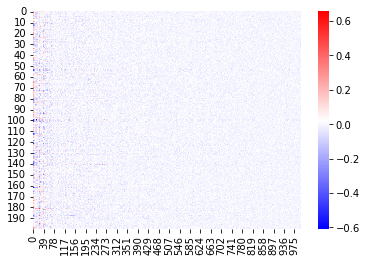

In [11]:
train_feature_path = work_dir + 'project_dir/dnn_feature_maps/pca_feature_maps/alexnet/pca_feature_maps_training.npy'
test_feature_path = work_dir + 'project_dir/dnn_feature_maps/pca_feature_maps/alexnet/pca_feature_maps_test.npy'

train_feature_map = np.load(train_feature_path)
test_feature_map = np.load(test_feature_path)

print(train_feature_map.shape)
print(test_feature_map.shape)

# テスト画像による重みのKernel PCAの結果
seaborn.heatmap(test_feature_map, cmap='bwr')

## Feature mapsとEEGデータの間のlinear regressionを行う

In [29]:
def vectorized_correlation(x,y):
    dim = 0

    centered_x = x - x.mean(axis=dim, keepdims=True)
    centered_y = y - y.mean(axis=dim, keepdims=True)

    covariance = (centered_x * centered_y).sum(axis=dim, keepdims=True)

    bessel_corrected_covariance = covariance / (x.shape[dim] - 1)

    x_std = x.std(axis=dim, keepdims=True)+1e-8
    y_std = y.std(axis=dim, keepdims=True)+1e-8

    corr = bessel_corrected_covariance / (x_std * y_std)

    return corr.ravel()

class OLS_pytorch(object):
    def __init__(self,use_gpu=False):
        self.coefficients = []
        self.use_gpu = use_gpu
        self.X = None
        self.y = None

    def fit(self,X,y):
        if len(X.shape) == 1:
            X = self._reshape_x(X)
        if len(y.shape) == 1:
            y = self._reshape_x(y)

        X =  self._concatenate_ones(X)

        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).float()
        if self.use_gpu:
            X = X.cuda()
            y = y.cuda()
        XtX = torch.matmul(X.t(),X)
        Xty = torch.matmul(X.t(),y.unsqueeze(2))
        XtX = XtX.unsqueeze(0)
        XtX = torch.repeat_interleave(XtX, y.shape[0], dim=0)
        betas_cholesky, _ = torch.solve(Xty, XtX)

        self.coefficients = betas_cholesky

    def predict(self, entry):
        if len(entry.shape) == 1:
            entry = self._reshape_x(entry)
        entry =  self._concatenate_ones(entry)
        entry = torch.from_numpy(entry).float()
        if self.use_gpu:
            entry = entry.cuda()
        prediction = torch.matmul(entry,self.coefficients)
        prediction = prediction.cpu().numpy()
        prediction = np.squeeze(prediction).T
        return prediction

    def score(self):
        prediction = torch.matmul(self.X,self.coefficients)
        prediction = prediction
        yhat = prediction
        ybar = (torch.sum(self.y,dim=1, keepdim=True)/self.y.shape[1]).unsqueeze(2)
        ssreg = torch.sum((yhat-ybar)**2,dim=1, keepdim=True)
        sstot = torch.sum((self.y.unsqueeze(2) - ybar)**2,dim=1, keepdim=True)
        score = ssreg / sstot
        return score.cpu().numpy().ravel()

    def _reshape_x(self,X):
        return X.reshape(-1,1)

    def _concatenate_ones(self,X):
        ones = np.ones(shape=X.shape[0]).reshape(-1,1)
        return np.concatenate((ones,X),1)

In [37]:
def load_dnn_data(args):
	"""Loading the DNN feature maps of the training and test images, and of the
	ILSVRC-2012 test and validation images.
	Parameters
	----------
	args : Namespace
		Input arguments.
	Returns
	-------
	X_train : float
		Training images feature maps.
	X_test : float
		Test images feature maps.
	X_ilsvrc2012_val : float
		ILSVRC-2012 validation images feature maps.
	X_ilsvrc2012_test : float
		ILSVRC-2012 test images feature maps.
	"""

	### Loading the DNN feature maps ###
	# Feature maps directories
	data_dir = os.path.join('dnn_feature_maps', 'pca_feature_maps', args.dnn)
	training_file = 'pca_feature_maps_training.npy'
	test_file = 'pca_feature_maps_test.npy'
	# ilsvrc2012_val_file = 'pca_feature_maps_ilsvrc2012_val.npy'
	# ilsvrc2012_test_file = 'pca_feature_maps_ilsvrc2012_test.npy'
	# Loading the feature maps
	X_train = np.load(os.path.join(args.project_dir, data_dir, training_file))
	X_test = np.load(os.path.join(args.project_dir, data_dir, test_file))
	# X_ilsvrc2012_val = np.load(os.path.join(args.project_dir, data_dir,
	# 	ilsvrc2012_val_file))
	# X_ilsvrc2012_test = np.load(os.path.join(args.project_dir, data_dir,
	# 	ilsvrc2012_test_file))

	### Output ###
	return X_train, X_test # , X_ilsvrc2012_val, X_ilsvrc2012_test


def load_eeg_data(args):
	"""Loading the EEG within subjects (the training data of the subject of
	interest) and between subjects (the training data of the all other subjects
	except the subject of interest) data.
	Parameters
	----------
	args : Namespace
		Input arguments.
	Returns
	-------
	y_train_within : float
		Within subjects training EEG data.
	y_train_between : float
		Between subjects training EEG data.
	ch_names : list of str
		EEG channel names.
	times : float
		EEG time points.
	"""

	### Loading the EEG data ###
	y_train_within = []
	y_train_between = []
	for s in range(args.n_tot_sub):
		data_dir = os.path.join('eeg_dataset', 'preprocessed_data', 'sub-'+
			format(s+1,'02'), 'preprocessed_eeg_training.npy')
		data = np.load(os.path.join(args.project_dir, data_dir),
			allow_pickle=True).item()
		# Extracting the data while averaging across repetitions
		if s+1 == args.sub:
			y_train_within.append(np.mean(data['preprocessed_eeg_data'], 1))
		else:
			y_train_between.append(np.mean(data['preprocessed_eeg_data'], 1))
		ch_names = data['ch_names']
		times = data['times']
		del data
	# Averaging the between subjects data across subjects
	y_train_within = np.asarray(y_train_within[0])
	y_train_between = np.mean(np.asarray(y_train_between), 0)

	### Output ###
	return y_train_within, y_train_between, ch_names, times


def perform_regression(args, ch_names, times, X_train, X_test, y_train_within, y_train_between):
	"""Training a linear regression on the training images DNN feature maps (X)
	and training EEG data (Y), and use the trained weights to synthesize the EEG
	responses to the training and test images (within and between subjects), and
	to the test/validation ILSVRC-2012 images (within subjects).
	Parameters
	----------
	args : Namespace
		Input arguments.
	ch_names : list of str
		EEG channel names.
	times : float
		EEG time points.
	X_train : float
		Training images feature maps.
	X_test : float
		Test images feature maps.
	X_ilsvrc2012_val : float
		ILSVRC-2012 validation images feature maps.
	X_ilsvrc2012_test : float
		ILSVRC-2012 test images feature maps.
	y_train_within : float
		Within subjects training EEG data.
	y_train_between : float
		Between subjects training EEG data.
	"""

	### Fitting the regression at each time-point and channel ###
	eeg_shape = y_train_within.shape
	y_train_within = np.reshape(y_train_within, (y_train_within.shape[0],-1))
	y_train_between = np.reshape(y_train_between, (y_train_between.shape[0],-1))
	# Within subjects
	reg_within = OLS_pytorch(use_gpu=False)
	reg_within.fit(X_train, y_train_within.T)
	synt_train_within = np.reshape(reg_within.predict(X_train),
		(X_train.shape[0],eeg_shape[1], eeg_shape[2]))
	synt_test_within = np.reshape(reg_within.predict(X_test), (X_test.shape[0],
		eeg_shape[1],eeg_shape[2]))
	# synt_ilsvrc2012_val_within = np.reshape(reg_within.predict(
	# 	X_ilsvrc2012_val), (X_ilsvrc2012_val.shape[0],eeg_shape[1],
	# 	eeg_shape[2]))
	# synt_ilsvrc2012_test_within = np.reshape(reg_within.predict(
	# 	X_ilsvrc2012_test), (X_ilsvrc2012_test.shape[0],eeg_shape[1],
	# 	eeg_shape[2]))
	del reg_within
	# Between subjects
	reg_between = OLS_pytorch(use_gpu=False)
	reg_between.fit(X_train, y_train_between.T)
	synt_train_between = np.reshape(reg_between.predict(X_train),
		(X_train.shape[0],eeg_shape[1],eeg_shape[2]))
	synt_test_between = np.reshape(reg_between.predict(X_test),
		(X_test.shape[0],eeg_shape[1],eeg_shape[2]))
	del reg_between, X_train, X_test, y_train_within, y_train_between

	### Putting the data into dictionaries and saving ###
	print('\n>>> Saving the data <<<')
	# Creating the saving directories
	save_dir = os.path.join(args.project_dir, 'results', 'sub-'+
		format(args.sub,'02'), 'synthetic_eeg_data', 'linearizing_encoding',
		'dnn-'+args.dnn)
	if not os.path.exists(save_dir):
		os.makedirs(save_dir)
	# Training data
	data_dict = {
		'synthetic_data_within': synt_train_within,
		'synthetic_data_between': synt_train_between,
		'ch_names': ch_names,
		'times': times
		}
	file_name = 'synthetic_eeg_training.npy'
	np.save(os.path.join(save_dir, file_name), data_dict)
	# Test data
	data_dict = {
		'synthetic_data_within': synt_test_within,
		'synthetic_data_between': synt_test_between,
		'ch_names': ch_names,
		'times': times
		}
	file_name = 'synthetic_eeg_test.npy'
	np.save(os.path.join(save_dir, file_name), data_dict)
	# ILSVRC-2012 validation data
	# data_dict = {
	# 	'synthetic_data_within': synt_ilsvrc2012_val_within,
	# 	'ch_names': ch_names,
	# 	'times': times
	# 	}
	# file_name = 'synthetic_eeg_ilsvrc2012_val.npy'
	# np.save(os.path.join(save_dir, file_name), data_dict)
	# ILSVRC-2012 test data
	# data_dict = {
	# 	'synthetic_data_within': synt_ilsvrc2012_test_within,
	# 	'ch_names': ch_names,
	# 	'times': times
	# 	}
	# file_name = 'synthetic_eeg_ilsvrc2012_test.npy'
	# np.save(os.path.join(save_dir, file_name), data_dict)

In [38]:
"""Fitting a linear regression to predict EEG data using the DNN feature maps as
predictors. The linear regression is trained using the training images EEG data
(Y) and feature maps (X), and the learned weights are used to synthesize the EEG
data of the training and test images, and also of the ILSVRC-2012 test and
validation images. The linear regression is trained both within and between
subjects in a leave-one-subject out fashion.
Parameters
----------
sub : int
	Used subject.
n_tot_sub : int
	Total number of subjects.
dnn : str
	Used DNN network.
project_dir : str
	Directory of the project folder.
"""




# =============================================================================
# Input arguments
# =============================================================================
args = Args({
    'sub': 1, # subject
    'n_tot_sub': 1, # 10
    'dnn': 'alexnet',
    'project_dir': work_dir + 'project_dir'
})

print('>>> Predicting the EEG data <<<')
print('\nInput arguments:')
for key, val in vars(args).items():
	print('{:16} {}'.format(key, val))


# =============================================================================
# Loading the DNN feature maps
# =============================================================================
X_train, X_test = load_dnn_data(args)


# =============================================================================
# Loading the EEG data
# =============================================================================
y_train_within, y_train_between, ch_names, times = load_eeg_data(args)


# =============================================================================
# Training the linear regression and saving the predicted data
# =============================================================================
perform_regression(args, ch_names, times, X_train, X_test, y_train_within, y_train_between)

>>> Predicting the EEG data <<<

Input arguments:
sub              1
n_tot_sub        1
dnn              alexnet
project_dir      /content/drive/MyDrive/eeg_encoding-main/project_dir


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: ignored